In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"


In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

# Load raw events

In [3]:
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

print(files.keys())
bkg = read_h5_file(database_path, files["SM"])
# SM processes

neutral_boson = read_h5_file(database_path, files["neutral_boson"])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

leptoquark = read_h5_file(database_path, files["leptoquark"])
# A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

neutral_Higgs = read_h5_file(database_path, files["neutral_Higgs"])
# A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

charged_Higgs = read_h5_file(database_path, files["charged_Higgs"])
# A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino

dict_keys(['SM', 'neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs'])


# Load embedding model

In [4]:
model_hyper_parameters = load_toml_config("Transformer")
print(model_hyper_parameters)
feature_size = model_hyper_parameters["feature_size"]
embed_size = model_hyper_parameters["embed_size"]
num_heads = model_hyper_parameters["num_heads"]
num_layers = model_hyper_parameters["num_layers"]
hidden_dim = model_hyper_parameters["hidden_dim"]
output_dim = model_hyper_parameters["output_dim"]

embedding_model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)

{'feature_size': 3, 'embed_size': 16, 'num_heads': 8, 'num_layers': 4, 'hidden_dim': 256, 'output_dim': 4}


/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Embed events

In [5]:
from analysis import inference

In [6]:
from data import EventDataset

In [7]:
infer_test_num = 1000000
bkg_infer_test = bkg[:infer_test_num]
infer_dataset = EventDataset(bkg_infer_test)
infer_dataloader = DataLoader(infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

neutral_boson_infer_test = neutral_boson[:infer_test_num]
neutral_boson_infer_dataset = EventDataset(neutral_boson_infer_test)
neutral_boson_infer_dataloader = DataLoader(neutral_boson_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

leptoquark_infer_test = leptoquark[:infer_test_num]
leptoquark_infer_dataset = EventDataset(leptoquark_infer_test)
leptoquark_infer_dataloader = DataLoader(leptoquark_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

neutral_Higgs_infer_test = neutral_Higgs[:infer_test_num]
neutral_Higgs_infer_dataset = EventDataset(neutral_Higgs_infer_test)
neutral_Higgs_infer_dataloader = DataLoader(neutral_Higgs_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

charged_Higgs_infer_test = charged_Higgs[:infer_test_num]
charged_Higgs_infer_dataset = EventDataset(charged_Higgs_infer_test)
charged_Higgs_infer_dataloader = DataLoader(charged_Higgs_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

In [8]:
embedding_model.load_state_dict(torch.load(os.path.join("..", "model","emb_dim{}_type_scale{}.pt".format(output_dim, particle_type_scale))))
embedding_model.to(device)
bkg_embed_points = inference(embedding_model, infer_dataloader, embed_dim=output_dim)
print(bkg_embed_points.shape)

100%|██████████| 3907/3907 [00:08<00:00, 446.41it/s]

(1000000, 4)


In [9]:
neutral_boson_embed_points = inference(embedding_model, neutral_boson_infer_dataloader, embed_dim=output_dim)
leptoquark_embed_points = inference(embedding_model, leptoquark_infer_dataloader, embed_dim=output_dim)
neutral_Higgs_embed_points = inference(embedding_model, neutral_Higgs_infer_dataloader, embed_dim=output_dim)
charged_Higgs_embed_points = inference(embedding_model, charged_Higgs_infer_dataloader, embed_dim=output_dim)
print(neutral_boson_embed_points.shape)
print(leptoquark_embed_points.shape)
print(neutral_Higgs_embed_points.shape)
print(charged_Higgs_embed_points.shape)

100%|██████████| 2970/2970 [00:06<00:00, 445.24it/s]

(55969, 4)
(340544, 4)
(691283, 4)
(760272, 4)


In [10]:
bkg_max = np.max(bkg_embed_points, axis=0)
bkg_min = np.min(bkg_embed_points, axis=0)
neutral_boson_max = np.max(neutral_boson_embed_points, axis=0)
neutral_boson_min = np.min(neutral_boson_embed_points, axis=0)
leptoquark_max = np.max(leptoquark_embed_points, axis=0)
leptoquark_min = np.min(leptoquark_embed_points, axis=0)
neutral_Higgs_max = np.max(neutral_Higgs_embed_points, axis=0)
neutral_Higgs_min = np.min(neutral_Higgs_embed_points, axis=0)
charged_Higgs_max = np.max(charged_Higgs_embed_points, axis=0)
charged_Higgs_min = np.min(charged_Higgs_embed_points, axis=0)

total_max = np.max(np.array([bkg_max, neutral_boson_max, leptoquark_max, neutral_Higgs_max, charged_Higgs_max]), axis=0)
total_min = np.min(np.array([bkg_min, neutral_boson_min, leptoquark_min, neutral_Higgs_min, charged_Higgs_min]), axis=0)
def max_min_norm(x):
    return (x - total_min) / (total_max - total_min)

In [11]:
total_mean = np.mean(np.concatenate([bkg_embed_points, neutral_boson_embed_points, leptoquark_embed_points, neutral_Higgs_embed_points, charged_Higgs_embed_points]), axis=0)
print(total_mean)

[  96.99357097 -146.39087979 -153.85605629  108.39926677]


In [12]:
print(np.mean(bkg_embed_points, axis=0))
print(np.mean(neutral_boson_embed_points, axis=0))
print(np.mean(leptoquark_embed_points, axis=0))
print(np.mean(neutral_Higgs_embed_points, axis=0))
print(np.mean(charged_Higgs_embed_points, axis=0))

print(np.std(bkg_embed_points, axis=0))
print(np.std(neutral_boson_embed_points, axis=0))
print(np.std(leptoquark_embed_points, axis=0))
print(np.std(neutral_Higgs_embed_points, axis=0))
print(np.std(charged_Higgs_embed_points, axis=0))

[ 142.22429516 -210.5637264  -216.82394047  151.97081285]
[ 107.49868192 -170.3974457  -157.23823675  100.49644183]
[  92.40992917 -147.39542323 -141.82567862   92.84759197]
[  97.29988844 -146.78354556 -152.84559856  107.3628698 ]
[ 38.50199811 -59.40884638 -77.09169267  59.57889759]
[39.62446888 46.32809639 53.42689661 45.55258798]
[ 58.95394267  93.2374391  102.7732609   66.65062966]
[49.01006039 88.06157974 92.52305241 51.4553242 ]
[ 73.25371751 113.53638687 114.03525047  72.54167018]
[ 80.00088338 128.19388221 131.19922904  82.24994631]


# Split embed points

In [13]:
def create_exp_bkg_events(ori_bkg_events, ori_sig_events, sig_lambda, n=100000):
    """
    Create expperiment events by combining pure signal and background events with signal strength lambda, 
    and return the background events from remaining pure background events.
    Background: X = {X1,...,X_mb}, Xi ∼ pb Signal: Y = {Y1,...,Y_ms}, Experimental: W = {W1,...,W_n},
    """
    m_s = int(n * sig_lambda)
    m_b = n - m_s
    exp_events = np.concatenate((ori_bkg_events[:m_b], ori_sig_events[:m_s]))
    np.random.shuffle(exp_events)
    bkg_events = ori_bkg_events[m_b:m_b + n]
    return exp_events, bkg_events

In [14]:
def train_test_split(exp_events, bkg_events, test_ratio=0.2):
    """
    Split background data X = {X1,...,X_mb} into X1 and X2 of sizes m1 and m2 respectively.
    Split experimental data W = {W1,...,W_n} into W1 and W2 of sizes n1 and n2 respectively, with n2 = m2.
    Will assume n = mb for now.
    """
    n1 = int((1 - test_ratio) * len(exp_events))
    m1 = n1
    X1 = bkg_events[:m1]
    X2 = bkg_events[m1:]
    W1 = exp_events[:n1]
    W2 = exp_events[n1:]
    return X1, X2, W1, W2

In [15]:
class ClassifyDataset(Dataset):
    def __init__(self, exp_events ,bkg_events):
        """
        Experiment events labeled as 1, background events labeled as 0.
        """
        # Normalize the data
        bkg_events = max_min_norm(bkg_events)
        exp_events = max_min_norm(exp_events)

        bkg_events = torch.from_numpy(bkg_events).float()
        exp_events = torch.from_numpy(exp_events).float()
        self.events = torch.cat([bkg_events, exp_events], dim=0)
        self.labels = torch.cat([torch.zeros(len(bkg_events)), torch.ones(len(exp_events))])
    
    def __len__(self):
        return len(self.events)
    
    def __getitem__(self, idx):
        return self.events[idx], self.labels[idx]

In [16]:
def get_dataloaders(X1, W1, val_ratio):
    """
    Get dataloaders for training and validation sets.
    """
    n_train = int((1 - val_ratio) * len(W1))
    X1_train = X1[:n_train]
    X1_val = X1[n_train:]
    W1_train = W1[:n_train]
    W1_val = W1[n_train:]
    
    train_dataset = ClassifyDataset(W1_train, X1_train)
    val_dataset = ClassifyDataset(W1_val, X1_val)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=256)
    return train_dataloader, val_dataloader

In [118]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.01
n = 100000

exp_events, bkg_events = create_exp_bkg_events(bkg_embed_points, charged_Higgs_embed_points, sig_lambda, n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio)

# Classify Model

In [119]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLP, self).__init__()
        def make_layer(in_size, out_size):
            layer = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.LeakyReLU(),
                # nn.Dropout(0.1)
            )
            nn.init.kaiming_normal_(layer[0].weight, nonlinearity='leaky_relu')
            return layer
        self.layers = nn.Sequential(
            make_layer(input_size, hidden_sizes[0]),
            *[make_layer(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)],
            nn.Linear(hidden_sizes[-1], 1),
            nn.Sigmoid()
        )
    

    def forward(self, x):
        return self.layers(x).reshape(-1)
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

In [120]:
# class Deep(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer1 = nn.Linear(4, 8)
#         self.act1 = nn.ReLU()
#         self.layer2 = nn.Linear(8, 16)
#         self.act2 = nn.ReLU()
#         self.layer3 = nn.Linear(16, 16)
#         self.act3 = nn.ReLU()
#         self.output = nn.Linear(16, 1)
#         self.sigmoid = nn.Sigmoid()
 
#     def forward(self, x):
#         x = self.act1(self.layer1(x))
#         x = self.act2(self.layer2(x))
#         x = self.act3(self.layer3(x))
#         x = self.sigmoid(self.output(x))
#         x = x.squeeze()
#         return x

# naive_model = Deep()

# Train

In [121]:
class BinaryACCUpdater(nn.Module):
    def __init__(self, threshold=0.5):
        super(BinaryACCUpdater, self).__init__()
        self.total_acc = 0
        self.count = 0
        self.threshold = threshold
    def forward(self, output, label):
        acc = (output > self.threshold).float() == label
        mean_acc = acc.float().mean()
        self.update(mean_acc)
        return mean_acc
    def update(self, metric):
        self.total_acc += metric
        self.count += 1
    def compute(self):
        return self.total_acc / self.count
    def reset(self):
        self.total_acc = 0
        self.count = 0

In [122]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [123]:
from classify import train_model

In [124]:
opt_train_model  = torch.compile(train_model)

In [125]:
opt_train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-05-13 16:19:31
Epoch 1 / 50

100%|██████████| 125/125 [00:01<00:00, 119.41it/s, val_Accuracy=0.501, val_loss=0.695] 
<<<<<< reach best val_Accuracy : 0.5005625486373901 >>>>>>

================================================================================2024-05-13 16:19:43
Epoch 2 / 50

100%|██████████| 125/125 [00:00<00:00, 180.98it/s, val_Accuracy=0.502, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5015313029289246 >>>>>>

================================================================================2024-05-13 16:19:50
Epoch 3 / 50

100%|██████████| 125/125 [00:00<00:00, 579.31it/s, val_Accuracy=0.5, val_loss=0.693]  

================================================================================2024-05-13 16:19:58
Epoch 4 / 50

100%|██████████| 125/125 [00:00<00:00, 588.49it/s, val_Accuracy=0.498, val_loss=0.693]

========================================================================

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.693369,0.503758,0.694897,0.500563,1
1,0.693208,0.503242,0.693132,0.501531,2
2,0.693176,0.500078,0.693168,0.499781,3
3,0.693079,0.502375,0.693130,0.497625,4
4,0.693028,0.503047,0.693251,0.502625,5
5,0.692993,0.503969,0.693100,0.503063,6
6,0.693005,0.502867,0.693183,0.501094,7
7,0.693037,0.502648,0.693146,0.500750,8
8,0.693014,0.502039,0.693183,0.500000,9
9,0.692980,0.503188,0.693173,0.500938,10


# ROC

In [126]:
@torch.no_grad()
def predict(model, dataloader):
    model.eval()
    batch_size = dataloader.batch_size
    targets = np.zeros(len(dataloader.dataset))
    predictions = np.zeros(len(dataloader.dataset))
    for i, (features, labels) in enumerate(tqdm(dataloader)):
        features = features.to(device)
        outputs = model(features)
        targets[i * batch_size: (i + 1) * batch_size] = labels.numpy()
        predictions[i * batch_size: (i + 1) * batch_size] = outputs.cpu().numpy()
    return targets, predictions

In [127]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 125/125 [00:00<00:00, 1221.70it/s]


In [128]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [129]:
def calculate_auc(targets, predictions):
    fpr, tpr, thersholds = roc_curve(targets, predictions)
    auc_roc = auc(fpr, tpr)
    return fpr, tpr, auc_roc

In [130]:
def plot_roc_curve(fpr, tpr, auc_roc, title):
    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(auc_roc), lw=2)    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPT')
    plt.ylabel('TPR') 
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


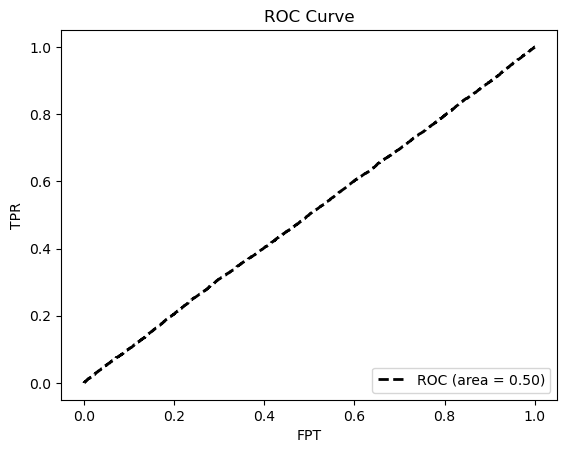

In [131]:
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
plot_roc_curve(fpr, tpr, auc_roc, "ROC Curve")

# Test statistics

In [132]:
class TestDataset(Dataset):
    def __init__(self, events):
        events = max_min_norm(events)
        self.events = torch.from_numpy(events).float()
    
    def __len__(self):
        return len(self.events)
    
    def __getitem__(self, idx):
        return self.events[idx]

In [133]:
@torch.no_grad()
def h_hat(classifier, W):
    classifier.eval()
    W_dataset = TestDataset(W)
    batch_size = 512
    W_dataloader = DataLoader(W_dataset, batch_size=batch_size)
    predictions = np.zeros(len(W))
    for i, features in enumerate(W_dataloader):
        features = features.to(device)
        outputs = classifier(features)
        predictions[i * batch_size: (i + 1) * batch_size] = outputs.cpu().numpy()
    return predictions

In [134]:
def lrt(h_W):
    pi = n1 / (m1 + n1)
    return np.log((1 - pi) / pi) + (1 / n2) * np.sum(np.log(h_W / (1 - h_W)))


def auc(h_W, h_X):
    result = h_W[:, None] > h_X[None, :]
    sum = np.sum(result)
    return sum / (m2 * n2)
    

def mce(h_W, h_X):
    pi = n1 / (m1 + n1)
    x_sum = np.sum(h_X > pi)
    w_sum = np.sum(h_W < pi)
    return 0.5 * ((1/m2) * x_sum + (1/n2) * w_sum)

In [135]:
%time
h_W2 = h_hat(naive_model, W2)
print(lrt(h_W2))

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.29 µs
0.0019448950358940213


In [136]:
%time
h_X2 = h_hat(naive_model, X2)
print(auc(h_W2, h_X2))

CPU times: user 20 µs, sys: 5 µs, total: 25 µs
Wall time: 3.81 µs
0.5057533125


In [137]:
%time
print(mce(h_W2, h_X2))

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 4.05 µs
0.49710000000000004


In [138]:
class Bootstrap_Permutation:
    def __init__(self, X2, W2, classifier):
        assert len(X2) == len(W2) # Make sure n2= m2
        self.m2 = len(X2)
        self.n2 = len(W2)
        self.n_union = self.m2 + self.n2

        self.X2 = X2
        self.W2 = W2
        self.union = np.concatenate((self.X2, self.W2))

        self.h_X2 = h_hat(classifier, self.X2)
        self.h_W2 = h_hat(classifier, self.W2)
        self.h_union = h_hat(classifier, self.union)


        self.lrt_exp = lrt(self.h_W2)
        self.auc_exp = auc(self.h_W2, self.h_X2)
        self.mce_exp = mce(self.h_W2, self.h_X2)

    def bootstrap(self, n):
        lrt_null = np.zeros(n)
        auc_null = np.zeros(n)
        mce_null = np.zeros(n)
        for i in tqdm(range(n)):
            lrt_null[i] = lrt(self.h_union[np.random.randint(0, self.n_union, self.n2)])
            auc_null[i] = auc(self.h_union[np.random.randint(0, self.n_union, self.n2)], self.h_union[np.random.randint(0, self.n_union, self.m2)])
            mce_null[i] = mce(self.h_union[np.random.randint(0, self.n_union, self.n2)], self.h_union[np.random.randint(0, self.n_union, self.m2)])
        return lrt_null, auc_null, mce_null
    def permutation(self, n):
        lrt_null = np.zeros(n)
        auc_null = np.zeros(n)
        mce_null = np.zeros(n)
        
        for i in tqdm(range(n)):
            sample1 = self.h_union.copy()
            sample2 = self.h_union.copy()
            np.random.shuffle(sample1)
            np.random.shuffle(sample2)
            lrt_null[i] = lrt(self.h_union[np.random.choice(self.n_union, self.n2, replace=False)])
            auc_null[i] = auc(sample1[:self.n2], sample1[self.n2:])
            mce_null[i] = mce(sample2[:self.n2], sample2[self.n2:])
        return lrt_null, auc_null, mce_null

In [139]:
bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model)

In [140]:
lrt_null_bootstarp, auc_null_bootstarp, mce_null_bootstarp = bootstrap_permutation.bootstrap(10000)

100%|██████████| 10000/10000 [23:39<00:00,  7.04it/s]


In [141]:
lrt_null_permutation, auc_null_permutation, mce_null_permutation = bootstrap_permutation.permutation(10000)

100%|██████████| 10000/10000 [23:32<00:00,  7.08it/s]


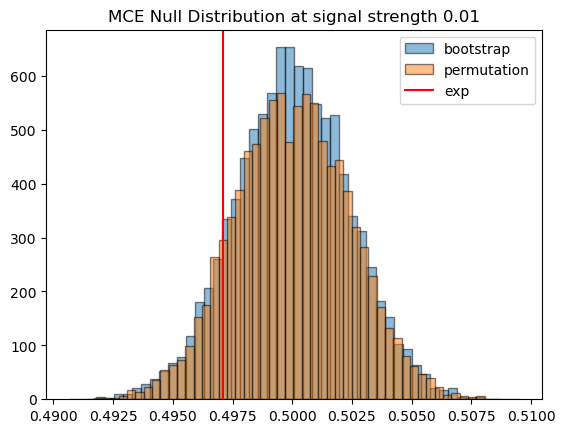

In [142]:
plt.hist(mce_null_bootstarp, bins=50, alpha=0.5, edgecolor='black', label="bootstrap")
plt.hist(mce_null_permutation, bins=50, alpha=0.5, edgecolor='black', label="permutation")
plt.axvline(bootstrap_permutation.mce_exp, color='r', label="exp")
plt.legend()
plt.title("MCE Null Distribution at signal strength {}".format(sig_lambda))
plt.show()

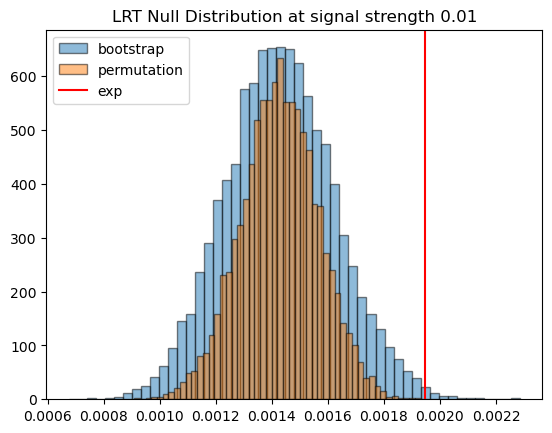

In [143]:
plt.hist(lrt_null_bootstarp, bins=50, alpha=0.5, edgecolor='black', label="bootstrap")
plt.hist(lrt_null_permutation, bins=50, alpha=0.5, edgecolor='black', label="permutation")
plt.axvline(bootstrap_permutation.lrt_exp, color='r', label="exp")
plt.legend()
plt.title("LRT Null Distribution at signal strength {}".format(sig_lambda))
plt.show()

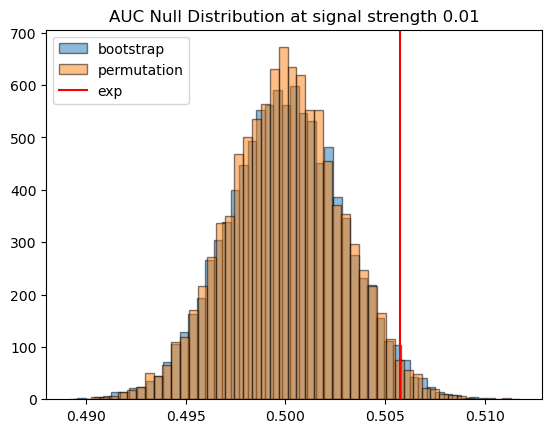

In [144]:
plt.hist(auc_null_bootstarp, bins=50, alpha=0.5, edgecolor='black', label="bootstrap")
plt.hist(auc_null_permutation, bins=50, alpha=0.5, edgecolor='black', label="permutation")
plt.axvline(bootstrap_permutation.auc_exp, color='r', label="exp")
plt.legend()
plt.title("AUC Null Distribution at signal strength {}".format(sig_lambda))
plt.show()

In [148]:
class LambdaEstimator:
    def __init__(self, X2, W2, classifier, T=0.5, bins=200):
        assert len(X2) == len(W2) # Make sure n2= m2
        self.m2 = len(X2)
        self.n2 = len(W2)

        self.X2 = X2
        self.W2 = W2

        self.h_X2 = h_hat(classifier, self.X2)
        self.h_W2 = h_hat(classifier, self.W2)
        result = h_X2[:, None] > h_W2[None, :]
        self.rho_W = np.sum(result, axis=0) / m2
        self.T = T
        self.bins = bins
        self.H_t = np.histogram(self.rho_W, bins=np.linspace(T, 1, bins + 1))[0]

In [149]:
lambda_estimator = LambdaEstimator(X2, W2, naive_model)

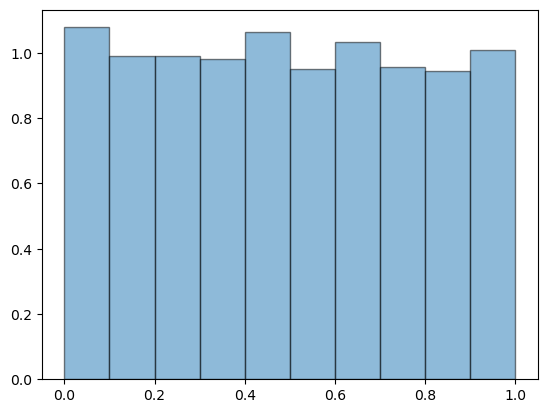

In [152]:
plt.hist(lambda_estimator.rho_W, bins=10, alpha=0.5, edgecolor='black', density=True)
plt.show()